In [1]:
import os
import sys
import datetime

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.deep_learning_models.EDSR_model import EDSR
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.constants import EDSR_PATCH_SIZE, EDSR_STRIDE, RANDOM_SEED, EDSR_SCALE_FACTOR

In [2]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))

In [3]:
X, Y = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="scale", patch_size=EDSR_PATCH_SIZE, stride=EDSR_STRIDE, scale_factor=EDSR_SCALE_FACTOR)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

X = X[:int(0.6 * len(X))]
Y = Y[:int(0.6 * len(Y))]

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (72315, 24, 24, 3), Y_train shape: (72315, 48, 48, 3)
X_val shape: (18079, 24, 24, 3), Y_val shape: (18079, 48, 48, 3)
X_test shape: (22599, 24, 24, 3), Y_test shape: (22599, 48, 48, 3)


X_train range: [0.0000, 1.0000]
Y_train range: [0.0000, 1.0000]
NaN in X_train: False, NaN in Y_train: False


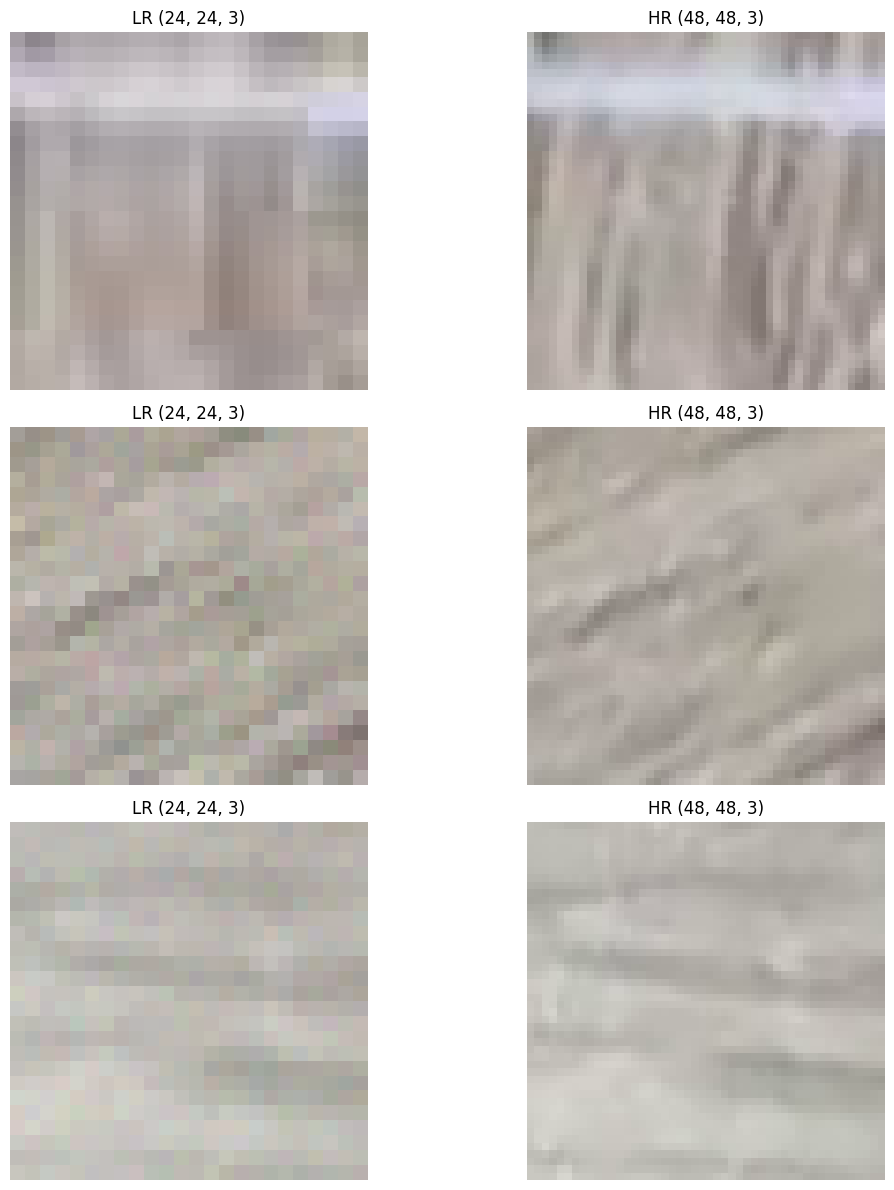

In [4]:
# Verificar rangos
print(f"X_train range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")
print(f"Y_train range: [{np.min(Y_train):.4f}, {np.max(Y_train):.4f}]")
print(f"NaN in X_train: {np.isnan(X_train).any()}, NaN in Y_train: {np.isnan(Y_train).any()}")

# Visualizar algunos pares aleatorios
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    axes[i, 0].imshow(X_train[idx])
    axes[i, 0].set_title(f"LR {X_train[idx].shape}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(Y_train[idx])
    axes[i, 1].set_title(f"HR {Y_train[idx].shape}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = EDSR()

model.setup_model(
    scale_factor=EDSR_SCALE_FACTOR, 
    num_res_blocks=16, 
    num_filters=64, 
    learning_rate=5e-5
)

Model: "EDSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                            

In [6]:
# Train EDSR and capture callbacks for metrics
history, time_cb, mem_cb = model.fit(
    X_train, Y_train, X_val, Y_val, 
    batch_size=16, 
    epochs=50
)

Training on GPU: /physical_device:GPU:0
Epoch 1/50
4520/4520 [==============================] - 163s 33ms/step - loss: 0.0256 - psnr: 21.8934 - ssim: 0.5712 - val_loss: 0.0020 - val_psnr: 28.0704 - val_ssim: 0.7724 - lr: 5.0000e-05 - epoch_time_sec: 162.6779 - gpu_mean_current_mb: 2691.8827 - gpu_peak_mb: 3080.3254
Epoch 2/50
4520/4520 [==============================] - 144s 32ms/step - loss: 0.0017 - psnr: 29.1193 - ssim: 0.7938 - val_loss: 0.0015 - val_psnr: 30.0029 - val_ssim: 0.8091 - lr: 5.0000e-05 - epoch_time_sec: 144.3484 - gpu_mean_current_mb: 2995.1069 - gpu_peak_mb: 3102.6904
Epoch 3/50
4520/4520 [==============================] - 151s 33ms/step - loss: 0.0015 - psnr: 30.2277 - ssim: 0.8151 - val_loss: 0.0015 - val_psnr: 30.4145 - val_ssim: 0.8183 - lr: 5.0000e-05 - epoch_time_sec: 150.6893 - gpu_mean_current_mb: 2995.1069 - gpu_peak_mb: 3102.6904
Epoch 4/50
4520/4520 [==============================] - 153s 34ms/step - loss: 0.0014 - psnr: 30.5689 - ssim: 0.8240 - val_loss: 

In [7]:
# Evaluate and prepare metrics dictionary
results = model.evaluate(X_test, Y_test)

# Extract last epoch train/val metrics from history
train_loss = float(history.history['loss'][-1]) if 'loss' in history.history else None
val_loss = float(history.history['val_loss'][-1]) if 'val_loss' in history.history else None
train_psnr = float(history.history['psnr'][-1]) if 'psnr' in history.history else None
val_psnr = float(history.history['val_psnr'][-1]) if 'val_psnr' in history.history else None
train_ssim = float(history.history['ssim'][-1]) if 'ssim' in history.history else None
val_ssim = float(history.history['val_ssim'][-1]) if 'val_ssim' in history.history else None

metrics_dict = {
    "eval_loss": float(results[0]),
    "eval_psnr": float(results[1]),
    "eval_ssim": float(results[2]),
    "final_train_loss": train_loss,
    "final_val_loss": val_loss,
    "final_train_psnr": train_psnr,
    "final_val_psnr": val_psnr,
    "final_train_ssim": train_ssim,
    "final_val_ssim": val_ssim,
    "epoch_time_sec": time_cb.mean_time_value(),
    "memory": mem_cb.as_dict()
}

707/707 [==============================] - 12s 16ms/step - loss: 0.0013 - psnr: 31.3232 - ssim: 0.8418
Loss: 0.0013, PSNR: 31.32 dB, SSIM: 0.8418


In [8]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

model.save(directory=f"models/EDSR/EDSR_{timestamp}", timestamp=timestamp)

Model saved to models/EDSR/EDSR_20250910_041330\EDSR_x2_20250910_041330.h5


In [9]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/EDSR/EDSR_{timestamp}/EDSR_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\EDSR\EDSR_20250910_041330\EDSR_20250910_041330_metrics.pkl
